In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [7]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml
from sklearn import datasets

In [8]:
X , y = datasets.load_wine(return_X_y=True)
y[y==1] = 0
y[y==2] = 1


In [9]:
X = StandardScaler().fit_transform(X)


In [10]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(130, 13)
(48, 13)


In [12]:
indices=np.arange(65)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:65]
x_train=np.concatenate((np.array(x_neg[0:65])[indices],x_pos)).reshape(-1,13)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [13]:
x_test = x_neg[65:130].reshape(-1,13)
y_test = y_neg[65:130].reshape(-1,1)

# Projection model

In [14]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [15]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [16]:
num_of_iterations = 20 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(48, 13)
Size: 10 Bits - FPR: 0.169231 - Time Taken to create filter(sec): 0.054697 



Size: 20 Bits - FPR: 0.092308 - Time Taken to create filter(sec): 0.126630 



Size: 30 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.045767 



Size: 40 Bits - FPR: 0.169231 - Time Taken to create filter(sec): 0.042410 



Size: 50 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.042661 



Size: 60 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.072649 



Size: 70 Bits - FPR: 0.123077 - Time Taken to create filter(sec): 0.024171 



Size: 80 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.024945 



Size: 90 Bits - FPR: 0.076923 - Time Taken to create filter(sec): 0.025506 



Size: 100 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.022484 



Size: 110 Bits - FPR: 0.107692 - Time Taken to create filter(sec): 0.022900 



Size: 120 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.041672 



Size: 13

Size: 1030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.064943 



Size: 1040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.176794 



Size: 1050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132266 



Size: 1060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084808 



Size: 1070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074651 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.068683 



Size: 1090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087514 



Size: 1100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.176271 



Size: 1110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.263779 



Size: 1120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111618 



Size: 1130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131653 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133466 



Size: 1150 Bits - FPR: 0.000

Size: 2050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118653 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104463 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116212 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115727 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.117782 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107138 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118976 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109757 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120943 



Size: 2140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107423 



Size: 2150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112389 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120313 



Size: 2170 Bits - FPR: 0.000

Size: 110 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.037789 



Size: 120 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.030346 



Size: 130 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.023684 



Size: 140 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.027579 



Size: 150 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.026634 



Size: 160 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.039683 



Size: 170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.040397 



Size: 180 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.027877 



Size: 190 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.037459 



Size: 200 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.032492 



Size: 210 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.030649 



Size: 220 Bits - FPR: 0.153846 - Time Taken to create filter(sec): 0.030226 



Size: 230 Bits - FPR: 0.061538 - Time Ta

Size: 1160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069377 



Size: 1170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076240 



Size: 1180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069945 



Size: 1190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.071470 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069288 



Size: 1210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.077747 



Size: 1220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072236 



Size: 1230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072482 



Size: 1240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078371 



Size: 1250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085996 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.075690 



Size: 1270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080332 



Size: 1280 Bits - FPR: 0.000

Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118648 



Size: 2190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122131 



Size: 2200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132124 



Size: 2210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133113 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.181471 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.177064 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.182691 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170561 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139505 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121635 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113645 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122912 



Size: 2300 Bits - FPR: 0.000

Size: 190 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.030183 



Size: 200 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.026537 



Size: 210 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.030279 



Size: 220 Bits - FPR: 0.076923 - Time Taken to create filter(sec): 0.030116 



Size: 230 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.030377 



Size: 240 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.040957 



Size: 250 Bits - FPR: 0.123077 - Time Taken to create filter(sec): 0.030064 



Size: 260 Bits - FPR: 0.076923 - Time Taken to create filter(sec): 0.033565 



Size: 270 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.030054 



Size: 280 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.032950 



Size: 290 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.033231 



Size: 300 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.037630 



Size: 310 Bits - FPR: 0.061538 - Time Ta

Size: 1240 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.071506 



Size: 1250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072714 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082444 



Size: 1270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074577 



Size: 1280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072660 



Size: 1290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084129 



Size: 1300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.075389 



Size: 1310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072768 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076629 



Size: 1330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090318 



Size: 1340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.075591 



Size: 1350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074933 



Size: 1360 Bits - FPR: 0.000

Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113391 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119185 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119672 



Size: 2300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114057 



Size: 2310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127307 



Size: 2320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113142 



Size: 2330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115194 



Size: 2340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126706 



Size: 2350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115814 



Size: 2360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126084 



Size: 2370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120707 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130852 



Size: 2390 Bits - FPR: 0.000

Size: 310 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.097675 



Size: 320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107494 



Size: 330 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.074345 



Size: 340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.044411 



Size: 350 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.093973 



Size: 360 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.095758 



Size: 370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.057767 



Size: 380 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.038697 



Size: 390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.037711 



Size: 400 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.091556 



Size: 410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105612 



Size: 420 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.072323 



Size: 430 Bits - FPR: 0.030769 - Time Ta

Size: 1340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110043 



Size: 1350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106232 



Size: 1360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100661 



Size: 1370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111532 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104805 



Size: 1390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.117624 



Size: 1400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113937 



Size: 1410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110930 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107178 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107941 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108958 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109987 



Size: 1460 Bits - FPR: 0.000

Size: 2360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183433 



Size: 2370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.178118 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.164952 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170902 



Size: 2400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.171423 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.176349 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.180017 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.178967 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.182141 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.177796 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.176239 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183526 



Size: 2480 Bits - FPR: 0.000

Size: 390 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.101033 



Size: 400 Bits - FPR: 0.076923 - Time Taken to create filter(sec): 0.055374 



Size: 410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047435 



Size: 420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056464 



Size: 430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.063044 



Size: 440 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.054903 



Size: 450 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.058691 



Size: 460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.051541 



Size: 470 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.059083 



Size: 480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.057114 



Size: 490 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.059397 



Size: 500 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.057571 



Size: 510 Bits - FPR: 0.061538 - Time Ta

Size: 1410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108087 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113760 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114150 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105213 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114991 



Size: 1460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110253 



Size: 1470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122348 



Size: 1480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108721 



Size: 1490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110345 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116976 



Size: 1510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125192 



Size: 1520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112682 



Size: 1530 Bits - FPR: 0.000

Size: 2440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.176833 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170947 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.296300 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.412047 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.258116 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.177882 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.178381 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.164568 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.178882 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.177372 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170799 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.179521 



Size: 2560 Bits - FPR: 0.000

Size: 470 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.100272 



Size: 480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088545 



Size: 490 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.083569 



Size: 500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087217 



Size: 510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099118 



Size: 520 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.078220 



Size: 530 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.061470 



Size: 540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.064352 



Size: 550 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.057226 



Size: 560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.061608 



Size: 570 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.067162 



Size: 580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.065655 



Size: 590 Bits - FPR: 0.000000 - Time Ta

Size: 1490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120571 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110073 



Size: 1510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129319 



Size: 1520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118709 



Size: 1530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116917 



Size: 1540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121170 



Size: 1550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121228 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126055 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116948 



Size: 1580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.199888 



Size: 1590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130520 



Size: 1600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121462 



Size: 1610 Bits - FPR: 0.000

Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.177144 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.160891 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.176780 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.167176 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.186058 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.252165 



Size: 2580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.285425 



Size: 2590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.225128 



Size: 2600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170525 



Size: 2610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.194303 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.178662 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.178928 



Size: 2640 Bits - FPR: 0.000

Size: 570 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.066753 



Size: 580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.064663 



Size: 590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.073449 



Size: 600 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.079775 



Size: 610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.066547 



Size: 620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.061096 



Size: 630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.067600 



Size: 640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.071578 



Size: 650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.067117 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062723 



Size: 670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.068249 



Size: 680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074190 



Size: 690 Bits - FPR: 0.000000 - Time Ta

Size: 1600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130647 



Size: 1610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125080 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133321 



Size: 1630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149492 



Size: 1640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.197774 



Size: 1650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170116 



Size: 1660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.190185 



Size: 1670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.202611 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.184735 



Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145340 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127839 



Size: 1710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124804 



Size: 1720 Bits - FPR: 0.000

Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144328 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138641 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140007 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137614 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146925 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.159882 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.160020 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148617 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139353 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148944 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138293 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137339 



Size: 2750 Bits - FPR: 0.000

Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052931 



Size: 670 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.054638 



Size: 680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062307 



Size: 690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.065541 



Size: 700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.054663 



Size: 710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050189 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049681 



Size: 730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050523 



Size: 740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.060540 



Size: 750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072363 



Size: 760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.061403 



Size: 770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.053416 



Size: 780 Bits - FPR: 0.000000 - Time Ta

Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122680 



Size: 1710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102404 



Size: 1720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093291 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091586 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093098 



Size: 1750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093165 



Size: 1760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098192 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092445 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092595 



Size: 1790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.097400 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092602 



Size: 1810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093940 



Size: 1820 Bits - FPR: 0.000

Size: 2730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.186427 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.184251 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.185783 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.182798 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.185643 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188661 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188766 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.185197 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.187739 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183543 



Size: 2830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.184456 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.191420 



Size: 2850 Bits - FPR: 0.000

Size: 750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076383 



Size: 760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072793 



Size: 770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074473 



Size: 780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087052 



Size: 790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078242 



Size: 800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.073977 



Size: 810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079819 



Size: 820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089778 



Size: 830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076461 



Size: 840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086562 



Size: 850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082553 



Size: 860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092752 



Size: 870 Bits - FPR: 0.000000 - Time Ta

Size: 1770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136573 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128218 



Size: 1790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137418 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133520 



Size: 1810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144148 



Size: 1820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137792 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145126 



Size: 1840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135934 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141242 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131464 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143707 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143727 



Size: 1890 Bits - FPR: 0.000

Size: 2790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.239972 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.236642 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.185852 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.182632 



Size: 2830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.185606 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.198619 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.193753 



Size: 2860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.200536 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.203009 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.206718 



Size: 2890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.198263 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.195451 



Size: 2910 Bits - FPR: 0.000

Size: 810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079714 



Size: 820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076576 



Size: 830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074762 



Size: 840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081483 



Size: 850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078538 



Size: 860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.075480 



Size: 870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101222 



Size: 880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079318 



Size: 890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076440 



Size: 900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074518 



Size: 910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085706 



Size: 920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080615 



Size: 930 Bits - FPR: 0.000000 - Time Ta

Size: 1840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147663 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139581 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142422 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137181 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136024 



Size: 1890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139230 



Size: 1900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.177891 



Size: 1910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135894 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146653 



Size: 1930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145464 



Size: 1940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147351 



Size: 1950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138875 



Size: 1960 Bits - FPR: 0.000

Size: 2860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188716 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.190080 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.195958 



Size: 2890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.189579 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188129 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.196139 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.195792 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.191989 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.210715 



Size: 2950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.228506 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.194382 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.193663 



Size: 2980 Bits - FPR: 0.000

Size: 880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085157 



Size: 890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076234 



Size: 900 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.078003 



Size: 910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086521 



Size: 920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083134 



Size: 930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081825 



Size: 940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083582 



Size: 950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080625 



Size: 960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.075219 



Size: 970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087208 



Size: 980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090942 



Size: 990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123449 



Size: 1000 Bits - FPR: 0.000000 - Time T

Size: 1900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147599 



Size: 1910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135228 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146741 



Size: 1930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135712 



Size: 1940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148745 



Size: 1950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.179324 



Size: 1960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137785 



Size: 1970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141613 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138930 



Size: 1990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140126 



Size: 2000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139024 



Size: 2010 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141322 



Size: 2020 Bits - FPR: 0.000

Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.197066 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.197935 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.193381 



Size: 2950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.193873 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.228855 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.309452 



Size: 2980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.336215 



Size: 2990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.295343 



Size: 3000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.252390 



~~~~~~~~ Iteration 12 ~~~~~~~~ 

(48, 13)
Size: 10 Bits - FPR: 0.123077 - Time Taken to create filter(sec): 0.038999 



Size: 20 Bits - FPR: 0.107692 - Time Taken to create filter(sec): 0.039797 



Size: 30 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.032

Size: 940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116207 



Size: 950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115355 



Size: 960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091307 



Size: 970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087500 



Size: 980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088579 



Size: 990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092607 



Size: 1000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083045 



Size: 1010 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085409 



Size: 1020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089283 



Size: 1030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085035 



Size: 1040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091315 



Size: 1050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096564 



Size: 1060 Bits - FPR: 0.000000 - 

Size: 1970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143928 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.173946 



Size: 1990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.199055 



Size: 2000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.209484 



Size: 2010 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.227882 



Size: 2020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.204729 



Size: 2030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.243508 



Size: 2040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.169607 



Size: 2050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149045 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143974 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142248 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148041 



Size: 2090 Bits - FPR: 0.000

Size: 3000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.198203 



~~~~~~~~ Iteration 13 ~~~~~~~~ 

(48, 13)
Size: 10 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.035472 



Size: 20 Bits - FPR: 0.092308 - Time Taken to create filter(sec): 0.037707 



Size: 30 Bits - FPR: 0.123077 - Time Taken to create filter(sec): 0.029565 



Size: 40 Bits - FPR: 0.076923 - Time Taken to create filter(sec): 0.030833 



Size: 50 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.031177 



Size: 60 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.031463 



Size: 70 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.033390 



Size: 80 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.036262 



Size: 90 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.033707 



Size: 100 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.029942 



Size: 110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.031871 



Size: 

Size: 1030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090426 



Size: 1040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085160 



Size: 1050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095116 



Size: 1060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092931 



Size: 1070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092869 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089880 



Size: 1090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095886 



Size: 1100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092777 



Size: 1110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091586 



Size: 1120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095885 



Size: 1130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095797 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.094164 



Size: 1150 Bits - FPR: 0.000

Size: 2050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109654 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104906 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109836 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108743 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112431 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108755 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112131 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110807 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112033 



Size: 2140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110239 



Size: 2150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115492 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128745 



Size: 2170 Bits - FPR: 0.000

Size: 80 Bits - FPR: 0.107692 - Time Taken to create filter(sec): 0.026338 



Size: 90 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.025257 



Size: 100 Bits - FPR: 0.092308 - Time Taken to create filter(sec): 0.027986 



Size: 110 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.022547 



Size: 120 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.024053 



Size: 130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.027741 



Size: 140 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.027784 



Size: 150 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.027012 



Size: 160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.029657 



Size: 170 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.029768 



Size: 180 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.026943 



Size: 190 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.027095 



Size: 200 Bits - FPR: 0.015385 - Time Take

Size: 1120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078418 



Size: 1130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069878 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069308 



Size: 1150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078757 



Size: 1160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.071719 



Size: 1170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.068023 



Size: 1180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078709 



Size: 1190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.075064 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105775 



Size: 1210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.156450 



Size: 1220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084011 



Size: 1230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.070069 



Size: 1240 Bits - FPR: 0.000

Size: 2140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115744 



Size: 2150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141819 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112898 



Size: 2170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108631 



Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111964 



Size: 2190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108265 



Size: 2200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112642 



Size: 2210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109578 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112057 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114127 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112631 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111506 



Size: 2260 Bits - FPR: 0.000

Size: 170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.030980 



Size: 180 Bits - FPR: 0.123077 - Time Taken to create filter(sec): 0.026938 



Size: 190 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.026367 



Size: 200 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.026594 



Size: 210 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.030172 



Size: 220 Bits - FPR: 0.153846 - Time Taken to create filter(sec): 0.031283 



Size: 230 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.030442 



Size: 240 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.030304 



Size: 250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.033329 



Size: 260 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.029755 



Size: 270 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.029905 



Size: 280 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.032473 



Size: 290 Bits - FPR: 0.015385 - Time Ta

Size: 1210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074273 



Size: 1220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074851 



Size: 1230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069576 



Size: 1240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076415 



Size: 1250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.071772 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.073406 



Size: 1270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.075816 



Size: 1280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.071788 



Size: 1290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.071951 



Size: 1300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076029 



Size: 1310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072267 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074762 



Size: 1330 Bits - FPR: 0.000

Size: 2240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114189 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112032 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115982 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111830 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113791 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115050 



Size: 2300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116837 



Size: 2310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116129 



Size: 2320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.161768 



Size: 2330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.159298 



Size: 2340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170407 



Size: 2350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142427 



Size: 2360 Bits - FPR: 0.000

Size: 310 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.042969 



Size: 320 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.033242 



Size: 330 Bits - FPR: 0.076923 - Time Taken to create filter(sec): 0.032389 



Size: 340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.033258 



Size: 350 Bits - FPR: 0.076923 - Time Taken to create filter(sec): 0.036207 



Size: 360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.037267 



Size: 370 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.039107 



Size: 380 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.038790 



Size: 390 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.035836 



Size: 400 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.035575 



Size: 410 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.035911 



Size: 420 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.038601 



Size: 430 Bits - FPR: 0.061538 - Time Ta

Size: 1350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079317 



Size: 1360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078834 



Size: 1370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074329 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079218 



Size: 1390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078537 



Size: 1400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080202 



Size: 1410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079034 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.077540 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078990 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079625 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078044 



Size: 1460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083902 



Size: 1470 Bits - FPR: 0.000

Size: 2370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134440 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127393 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127456 



Size: 2400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123363 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123821 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123095 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138743 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126771 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127350 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131297 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127424 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122544 



Size: 2490 Bits - FPR: 0.000

Size: 430 Bits - FPR: 0.046154 - Time Taken to create filter(sec): 0.047425 



Size: 440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.038377 



Size: 450 Bits - FPR: 0.061538 - Time Taken to create filter(sec): 0.038797 



Size: 460 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.038463 



Size: 470 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.038318 



Size: 480 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.048435 



Size: 490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056084 



Size: 500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043548 



Size: 510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.041626 



Size: 520 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.042805 



Size: 530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056985 



Size: 540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052919 



Size: 550 Bits - FPR: 0.000000 - Time Ta

Size: 1450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090123 



Size: 1460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096584 



Size: 1470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083416 



Size: 1480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.160330 



Size: 1490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102854 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102699 



Size: 1510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104158 



Size: 1520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083785 



Size: 1530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087344 



Size: 1540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103299 



Size: 1550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133993 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115284 



Size: 1570 Bits - FPR: 0.000

Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134238 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127964 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136464 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130489 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139586 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126297 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152836 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.168560 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147240 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127648 



Size: 2580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139115 



Size: 2590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127047 



Size: 2600 Bits - FPR: 0.000

Size: 530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050537 



Size: 540 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.047518 



Size: 550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.041190 



Size: 560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.046272 



Size: 570 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.044165 



Size: 580 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.054661 



Size: 590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.045397 



Size: 600 Bits - FPR: 0.030769 - Time Taken to create filter(sec): 0.044645 



Size: 610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.044110 



Size: 620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.045312 



Size: 630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.063278 



Size: 640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050867 



Size: 650 Bits - FPR: 0.015385 - Time Ta

Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114115 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123535 



Size: 1580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129342 



Size: 1590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087421 



Size: 1600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096130 



Size: 1610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104394 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091922 



Size: 1630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086082 



Size: 1640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098335 



Size: 1650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089941 



Size: 1660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085606 



Size: 1670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106733 



Size: 1680 Bits - FPR: 0.000

Size: 2590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148723 



Size: 2600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126896 



Size: 2610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135326 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127404 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134532 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130372 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137147 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127965 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135917 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127529 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141466 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126576 



Size: 2710 Bits - FPR: 0.000

Size: 640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.061205 



Size: 650 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.047997 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052430 



Size: 670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047495 



Size: 680 Bits - FPR: 0.015385 - Time Taken to create filter(sec): 0.049385 



Size: 690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.065977 



Size: 700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050973 



Size: 710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049939 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052052 



Size: 730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049864 



Size: 740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062046 



Size: 750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049921 



Size: 760 Bits - FPR: 0.000000 - Time Ta

Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107452 



Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089694 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091747 



Size: 1710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103681 



Size: 1720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089282 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089601 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103098 



Size: 1750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092698 



Size: 1760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091496 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104837 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091186 



Size: 1790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092044 



Size: 1800 Bits - FPR: 0.000

Size: 2710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142136 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130774 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140828 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136451 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141783 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132068 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147536 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132707 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147939 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138371 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150371 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132971 



Size: 2830 Bits - FPR: 0.000

Size: 750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093489 



Size: 760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087444 



Size: 770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.097819 



Size: 780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102610 



Size: 790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086572 



Size: 800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.054957 



Size: 810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.053666 



Size: 820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.067071 



Size: 830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056534 



Size: 840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055286 



Size: 850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055453 



Size: 860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069921 



Size: 870 Bits - FPR: 0.000000 - Time Ta

Size: 1790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104964 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092666 



Size: 1810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095007 



Size: 1820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105683 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096278 



Size: 1840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096140 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107115 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096693 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099982 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107743 



Size: 1890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108403 



Size: 1900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100737 



Size: 1910 Bits - FPR: 0.000

Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148109 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132822 



Size: 2830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147893 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136929 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.151046 



Size: 2860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135416 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149632 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137163 



Size: 2890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150805 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.158544 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.164124 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.179593 



Size: 2930 Bits - FPR: 0.000

In [17]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [18]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


# Normal Bloom Filter Values

In [19]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [20]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

6000
[48]


# FPR Comparison between Projection Model and Normal Bloom Filter

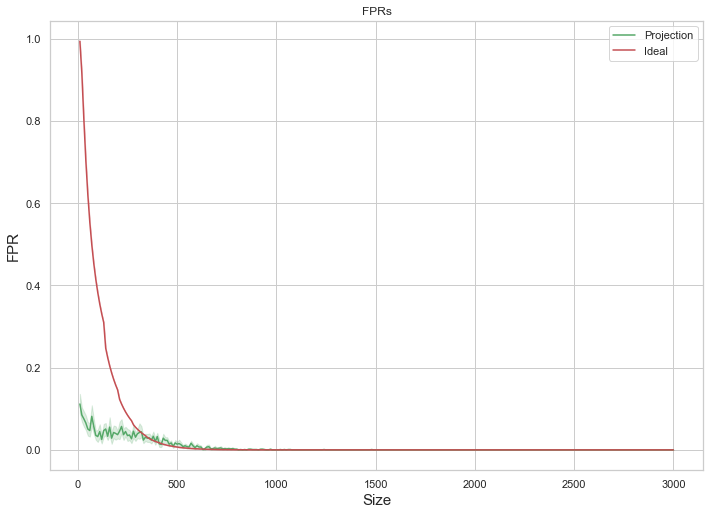

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [22]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [23]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [24]:
print(average_fprs)

[0.11153846153846154, 0.08461538461538463, 0.07538461538461538, 0.06538461538461539, 0.05076923076923077, 0.04692307692307692, 0.08153846153846153, 0.05692307692307693, 0.03538461538461538, 0.0323076923076923, 0.04461538461538461, 0.025384615384615384, 0.04692307692307692, 0.05076923076923077, 0.03307692307692307, 0.055384615384615386, 0.02846153846153846, 0.0423076923076923, 0.04, 0.03692307692307691, 0.04538461538461539, 0.05692307692307692, 0.03692307692307693, 0.04461538461538462, 0.03461538461538462, 0.03615384615384616, 0.026923076923076918, 0.04538461538461539, 0.03076923076923077, 0.039230769230769236, 0.04230769230769231, 0.04384615384615385, 0.023846153846153847, 0.030769230769230764, 0.02846153846153846, 0.029230769230769237, 0.023846153846153847, 0.03307692307692307, 0.02, 0.032307692307692315, 0.014615384615384617, 0.013076923076923078, 0.02846153846153846, 0.023076923076923078, 0.023076923076923078, 0.013846153846153847, 0.016923076923076923, 0.008461538461538461, 0.01692

In [25]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,0.993637,0.169231,0.111538,0.054697,0.040045
1,20,0.914742,0.092308,0.084615,0.126630,0.041318
2,30,0.803536,0.046154,0.075385,0.045767,0.036526
3,40,0.703366,0.169231,0.065385,0.042410,0.035278
4,50,0.620815,0.015385,0.050769,0.042661,0.033645


In [26]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Wine_rerun_epochs_100.csv')